step 1 do camera calibration

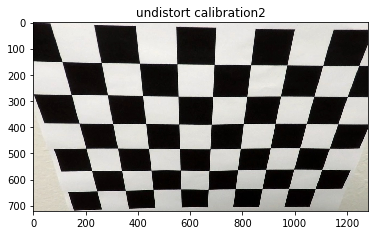

In [1]:
# %pylab inline
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

#test out undistort image 
img = cv2.imread("camera_cal/calibration1.jpg")
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

img = cv2.imread("camera_cal/calibration2.jpg")
img_undisort = cv2.undistort(img, mtx, dist, None, mtx)
plt.title("undistort calibration2")
plt.imshow(cv2.cvtColor(img_undisort,cv2.COLOR_BGR2RGB))
plt.show()



step 2:test out undistort image and perfom perspective transform
step 3: filter out bird eye view lane line based on color space (white and yellow)

In [2]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display
import cv2

image = cv2.imread('test_images/test5.jpg')
undistort_image = cv2.undistort(image, mtx, dist, None, mtx)

def scale(img, factor=255.0):
    scale_factor = np.max(img)/factor
    return (img/scale_factor).astype(np.uint8)

def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thres=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thres[0]) & (gradmag <= mag_thres[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output



def thresh(img, thresh_min, thresh_max):
        ret = np.zeros_like(img)
        ret[(img >= thresh_min) & (img <= thresh_max)] = 1
        return ret

def combined_binary_mask(img, ksize, mag_low, mag_high, dir_low, dir_high,\
                                    hls_low, hls_high, bright_low, bright_high):
    #kernel = np.ones((ksize, ksize), np.uint8)
    #img = cv2.morphologyEx(img.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    
    b = np.zeros((img.shape[0],img.shape[1]))
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    S = hsv[:,:,1]
    V = hsv[:,:,2]

    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]

    t_yellow_H = thresh(scale(H),10,30)
    t_yellow_S = thresh(scale(S),50,255)
    t_yellow_V = thresh(scale(V),150,255)

    t_white_R = thresh(scale(R),225,255)
    t_white_V = thresh(scale(V),230,255)
    
    dir_binary = dir_threshold(img,ksize, (dir_low, dir_high))
    mag_binary = mag_thresh(img, ksize, (mag_low, mag_high))

    b[(t_yellow_H==1) & (t_yellow_S==1) & (t_yellow_V==1)] = 1
    b[(t_white_R==1) | (t_white_V==1)] = 1
    b[(t_white_Rt_white_V + dir_binary + mag_binary) >= 3] = 1
    
    return b
    
def interactive_mask(ksize, mag_low, mag_high, dir_low, dir_high, hls_low, hls_high, bright_low, bright_high):
    combined = combined_binary_mask(image, ksize, mag_low, mag_high, dir_low, dir_high,\
                                    hls_low, hls_high, bright_low, bright_high)
    plt.figure(figsize=(10,10))
    plt.imshow(combined,cmap='gray')
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

interact(interactive_mask, ksize=(1,31,2), mag_low=(0,255), mag_high=(0,255),\
         dir_low=(0, np.pi/2), dir_high=(0, np.pi/2), hls_low=(0,255),\
         hls_high=(0,255), bright_low=(0,255), bright_high=(0,255))



NameError: name 't_white_Rt_white_V' is not defined

<function __main__.interactive_mask>

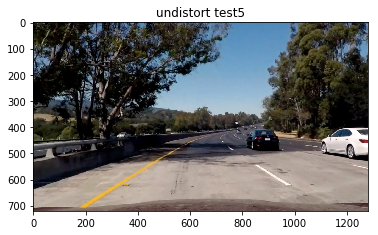

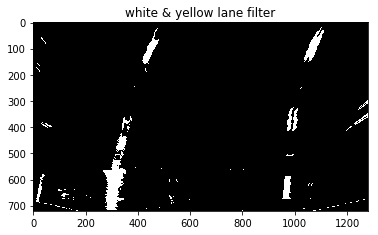

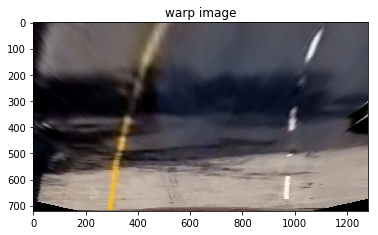

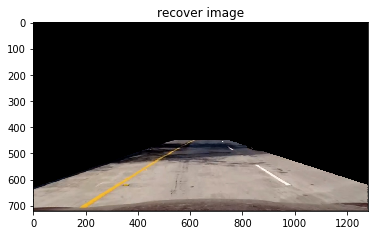

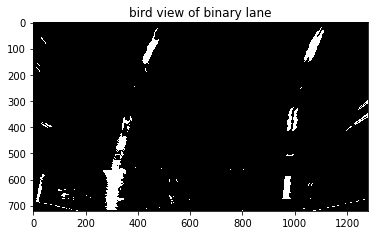

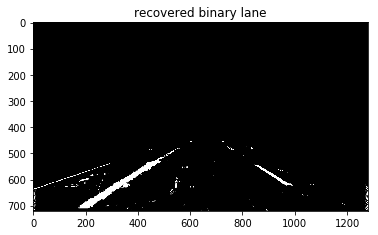

In [3]:
#apply to test images and calibrate
img = cv2.imread("test_images/test5.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistort_image = cv2.undistort(imgRGB, mtx, dist, None, mtx)

plt.title("undistort test5")
plt.imshow(undistort_image)
plt.show()
cv2.imwrite("output_images/undistort-test5.jpg", cv2.cvtColor(undistort_image,cv2.COLOR_BGR2RGB))


#do prospective transformation
#lane mask from fist hw
src = np.float32([[585, 450], [203, 720], [1127, 720], [695, 450]])

dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])

M = cv2.getPerspectiveTransform(src, dst)
M_prime = cv2.getPerspectiveTransform(dst, src)


def thresh(img, thresh_min, thresh_max):
    ret = np.zeros_like(img)
    ret[(img >= thresh_min) & (img <= thresh_max)] = 1
    return ret

#filter out color space to split white and yellow lane 
def filter_lane_color(img):
    
    #kernel = np.ones((5, 5), np.uint8)
    #img = cv2.morphologyEx(img.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    
    binary = np.zeros((img.shape[0], img.shape[1]))
    
    #add sobelx filter against shade and light
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3))
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    binary[scaled_sobel >= 30] = 1

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    S = hsv[:,:,1]
    V = hsv[:,:,2]

    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]

    t_yellow_H = thresh(H,10,30)
    t_yellow_S = thresh(S,50,255)
    t_yellow_V = thresh(V,150,255)

    t_white_R = thresh(R,225,255)
    t_white_V = thresh(V,230,255)

    binary[(t_yellow_H==1) & (t_yellow_S==1) & (t_yellow_V==1)] = 1
    binary[(t_white_R==1)|(t_white_V==1)] = 1
    
    return binary

binary_1 = filter_lane_color(cv2.warpPerspective(undistort_image, M, img_size, flags=cv2.INTER_LINEAR))
plt.title("white & yellow lane filter")
plt.imshow(binary_1,cmap ='gray')
plt.show()
cv2.imwrite('output_images/color_filter.jpg',(np.dstack((binary_1,binary_1,binary_1))*255).astype(np.uint8))

#wrap prospective of undistort image
warped = cv2.warpPerspective(undistort_image, M, img_size, flags=cv2.INTER_LINEAR)
recover = cv2.warpPerspective(warped, M_prime, img_size, flags=cv2.INTER_LINEAR)

plt.title("warp image")
plt.imshow(warped)
plt.show()
cv2.imwrite("output_images/warped-test5.jpg", cv2.cvtColor(warped,cv2.COLOR_BGR2RGB))

plt.title("recover image")
plt.imshow(recover)
plt.show()
cv2.imwrite("output_images/recover-test5.jpg", cv2.cvtColor(recover,cv2.COLOR_BGR2RGB))


binary_warped = filter_lane_color(warped)

binary_recover = cv2.warpPerspective(binary_warped, M_prime, img_size, flags=cv2.INTER_LINEAR)
plt.title("bird view of binary lane")
plt.imshow(binary_warped,cmap ='gray')

plt.show()
plt.title("recovered binary lane")
plt.imshow(binary_recover,cmap ='gray')
plt.show()

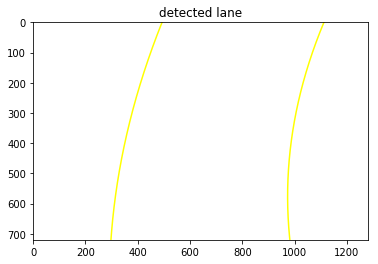

In [4]:
def get_left_right_fit(binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    #try to find lane after perspective transformation, copy from given material
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    out_img[ploty.astype('int'),left_fitx.astype('int')] = [0, 255, 255]
    out_img[ploty.astype('int'),right_fitx.astype('int')] = [0, 255, 255]
    
    y_eval = binary_warped.shape[0]
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    mid = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    return left_fit, right_fit, left_curverad,right_curverad, mid

left_fit, right_fit, _,_,_ = get_left_right_fit(binary_warped)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.title("detected lane")
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [5]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 0.7, window_img, 0.3, 0)

plt.title("plot line windows")
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()
cv2.imwrite("output_images/lane_fit-test5.jpg", result)

NameError: name 'nonzeroy' is not defined

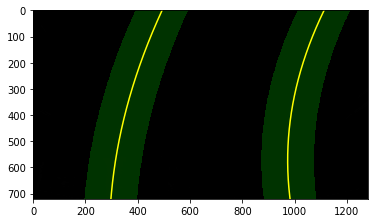

In [6]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

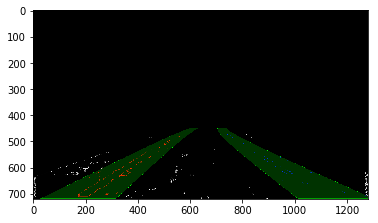

In [7]:
left_fit, right_fit, left_curverad, right_curverad, mid = get_left_right_fit(binary_warped)
result_recover = cv2.warpPerspective(result, M_prime, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(result_recover)
plt.show()

619.75441847 393.526698607


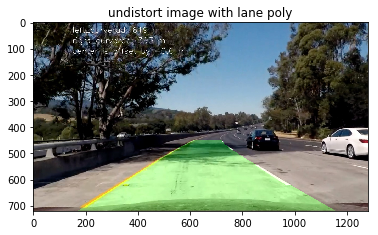

True

In [8]:
def overlay(undist, warped):
    left_fit, right_fit, left_curverad, right_curverad, mid = get_left_right_fit(warped)
    print (left_curverad, right_curverad)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_prime, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    try:
        text_l = "left_curverad: " + str(int(left_curverad)) + " m"
        text_r = "right_curverad: " + str(int(right_curverad)) + " m"
        mid = "center is offset by " + str(round( mid,2)) + " m"
    except:
        text_l = "left_curverad: can't find"
        text_r = "right_curverad: can't find"
        mid = "center can't find"
    cv2.putText(result, text_l, (150,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    cv2.putText(result, text_r, (150,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    cv2.putText(result, mid, (150,120), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    return result

plt.title("undistort image with lane poly")
result_recover = overlay(undistort_image, binary_warped)
plt.imshow(result_recover)
plt.show()
cv2.imwrite("output_images/plottest5.jpg", cv2.cvtColor(result_recover,cv2.COLOR_BGR2RGB))


434.38842548 275.977622261


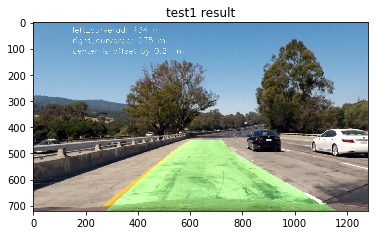

444.454485283 353.12444439


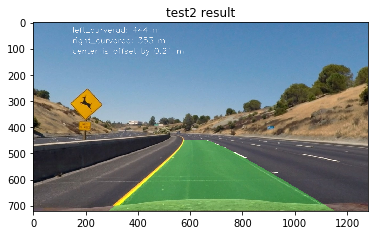

528.29220023 521.954132649


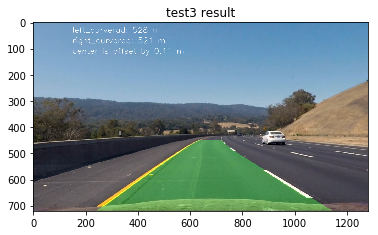

731.508496628 334.878440506


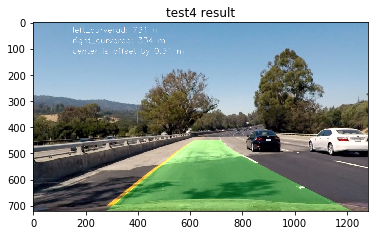

619.75441847 393.526698607


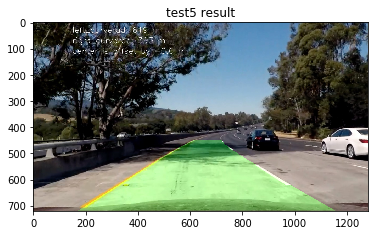

2707.87984069 572.623511385


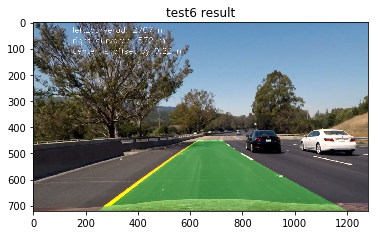

In [9]:
def render_lane_line_overlay(img,mtx=mtx,dist=dist, M=M):
    img_size = (img.shape[1], img.shape[0])
    undist = cv2.undistort(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), mtx, dist, None, mtx)
    prospective = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    
    warped = filter_lane_color(prospective)
    #plt.imshow(binary_wrap,cmap='gray')
    #plt.show()
    left_fit, right_fit, left_curverad, right_curverad, mid = get_left_right_fit(warped)
    print (left_curverad, right_curverad)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_prime, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    try:
        text_l = "left_curverad: " + str(int(left_curverad)) + " m"
        text_r = "right_curverad: " + str(int(right_curverad)) + " m"
        mid = "center is offset by " + str(round( mid,2)) + " m"
    except:
        text_l = "left_curverad: can't find"
        text_r = "right_curverad: can't find"
        mid = "center can't find"
    cv2.putText(result, text_l, (150,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    cv2.putText(result, text_r, (150,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    cv2.putText(result, mid, (150,120), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    return result

img = cv2.imread("test_images/test1.jpg")
plt.title('test1 result')
plt.imshow(render_lane_line_overlay(img))
plt.show()

img = cv2.imread("test_images/test2.jpg")
plt.title('test2 result')
plt.imshow(render_lane_line_overlay(img))
plt.show()

img = cv2.imread("test_images/test3.jpg")
plt.title('test3 result')
plt.imshow(render_lane_line_overlay(img))
plt.show()

img = cv2.imread("test_images/test4.jpg")
plt.title('test4 result')
plt.imshow(render_lane_line_overlay(img))
plt.show()

img = cv2.imread("test_images/test5.jpg")
plt.title('test5 result')
plt.imshow(render_lane_line_overlay(img))
plt.show()

img = cv2.imread("test_images/test6.jpg")
plt.title('test6 result')
plt.imshow(render_lane_line_overlay(img))
plt.show()

In [12]:
from collections import deque

buffer_size = 5

def get_avg_left_right_fit(binary_wrap, left_fits=deque(maxlen=buffer_size), right_fits=deque(maxlen=buffer_size), dists=deque(maxlen=buffer_size)):
    left_fit, right_fit, left_curverad, right_curverad, mid = get_left_right_fit(binary_wrap)
    
    ploty = np.linspace(0, binary_wrap.shape[0]-1, binary_wrap.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    
    #calculate distance between left lane points and right lane points
    dist = np.linalg.norm(left_fitx-right_fitx)
    
    #sanity check
    #if distance between large and right lane points are 20% longer shorter than average, drop it.
    if (len(dists) == 0) or (abs(dist-np.average(dists)) < 0.2*np.average(dists)):
        left_fits.append(left_fit)
        right_fits.append(right_fit)
        dists.append(dist)
    
    weights = np.arange(1,len(left_fits)+1)/len(left_fits)
    return np.average(left_fits,0,weights[-len(left_fits):]), np.average(right_fits,0,weights[-len(right_fits):]), left_curverad, right_curverad, mid

def render_avg_lane_line_overlay(img,mtx=mtx,dist=dist, M=M):
    #undistort image first
    undist = cv2.undistort(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), mtx, dist, None, mtx)
    
    #apply lane filter on top of wrap prospective undistort image
    warped = filter_lane_color(cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR))

    left_fit, right_fit, left_curverad, right_curverad, mid = get_avg_left_right_fit(warped)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_prime, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    text_l = "left_curverad: " + str(int(left_curverad)) + " m"
    text_r = "right_curverad: " + str(int(right_curverad)) + " m"
    mid = "center is offset by " + str(round( mid,2)) + " m"
    
    
    #dist = np.linalg.norm(left_fitx-right_fitx)
    
    cv2.putText(result, text_l, (150,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    cv2.putText(result, text_r, (150,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    cv2.putText(result, mid, (150,120), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    
    #cv2.putText(result, str(abs(d0-d1)), (150,160), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    
    #cv2.putText(result, "distance" + str(dist), (150,200), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 1,  lineType = cv2.LINE_AA)
    
    return result




In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve
img = None

def process(img):
    return cv2.cvtColor(render_avg_lane_line_overlay(img), cv2.COLOR_BGR2RGB)

#Create video file pipeline
counter=0
output = 'test_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
test_clip = clip1.fl_image(process)
%time test_clip.write_videofile(output, audio=False)
print(counter)
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video test_video.mp4
[MoviePy] Writing video test_video.mp4


100%|█████████▉| 1260/1261 [04:17<00:00,  4.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video.mp4 

CPU times: user 3min 54s, sys: 1min 5s, total: 4min 59s
Wall time: 4min 18s
0
